# 1. Load the model

In [23]:
import os
import time
import pypianoroll
from pypianoroll import Multitrack, Track
import torch.utils.data as Data
from matplotlib import pyplot as plt
from vae_rnn import *

In [2]:
# list the models
path = os.getcwd() + '/models/'
models = [ m for m in os.listdir(path) if '.pt' in m ]

for i, m in enumerate(models):
    print('[{}]: {}'.format(i, m))

[0]: model_L5E-03_BETA9E-01_loss3E+01_relu_gru16_e50_b256.pt
[1]: model_L5E-03_loss2E+01_relu_gru16_e50_b256.pt
[2]: model_L5E-03_loss1E+02_relu_gru2_e10_b256.pt


In [3]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)

In [4]:
vae.load_state_dict(torch.load(path + models[0]))

In [5]:
train_x_reduced = np.load('./../explore_data/data/train_x_drum_reduced.npy')
print(train_x_reduced.shape)

(34452, 96, 9)


In [62]:
def writeData2Midi(data, f='interpolation'):
    
    t = time.strftime("-%Y%m%d-%H%M%S")
    filename = f + t + '.mid'
    # filename = f + '.mid'
    filepath = './outputs/' + filename
    
    track = np.append(data, np.zeros((data.shape[0], 119)), axis=1)
    # track = np.where(track == 1, 128, 0)
    track = track * 128
    track = Track(pianoroll=track, program=0, is_drum=True)
    mt = Multitrack(
        tracks=[track],
        tempo=80.0,
        beat_resolution=24,
    )
    
    pypianoroll.write(mt, filepath)

In [6]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

In [7]:
TESTING_RATIO = 0.1
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

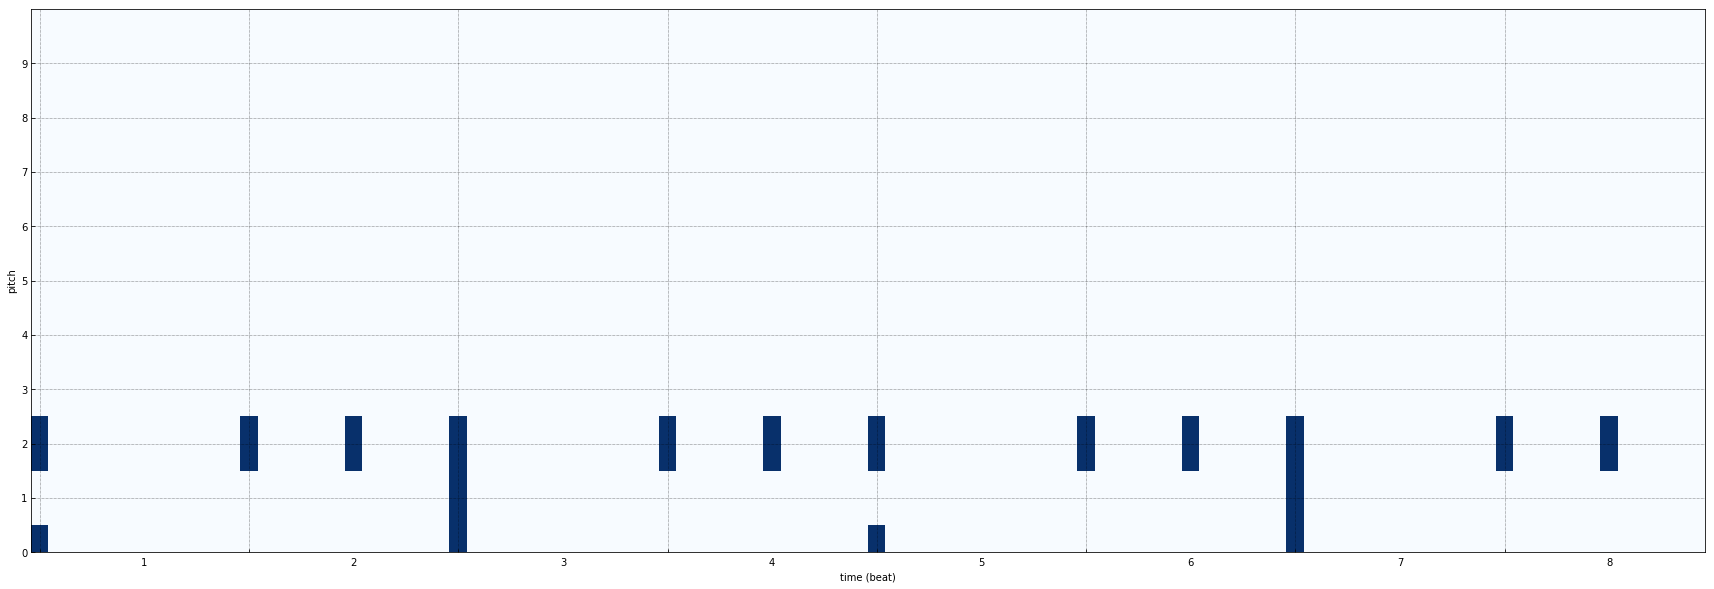

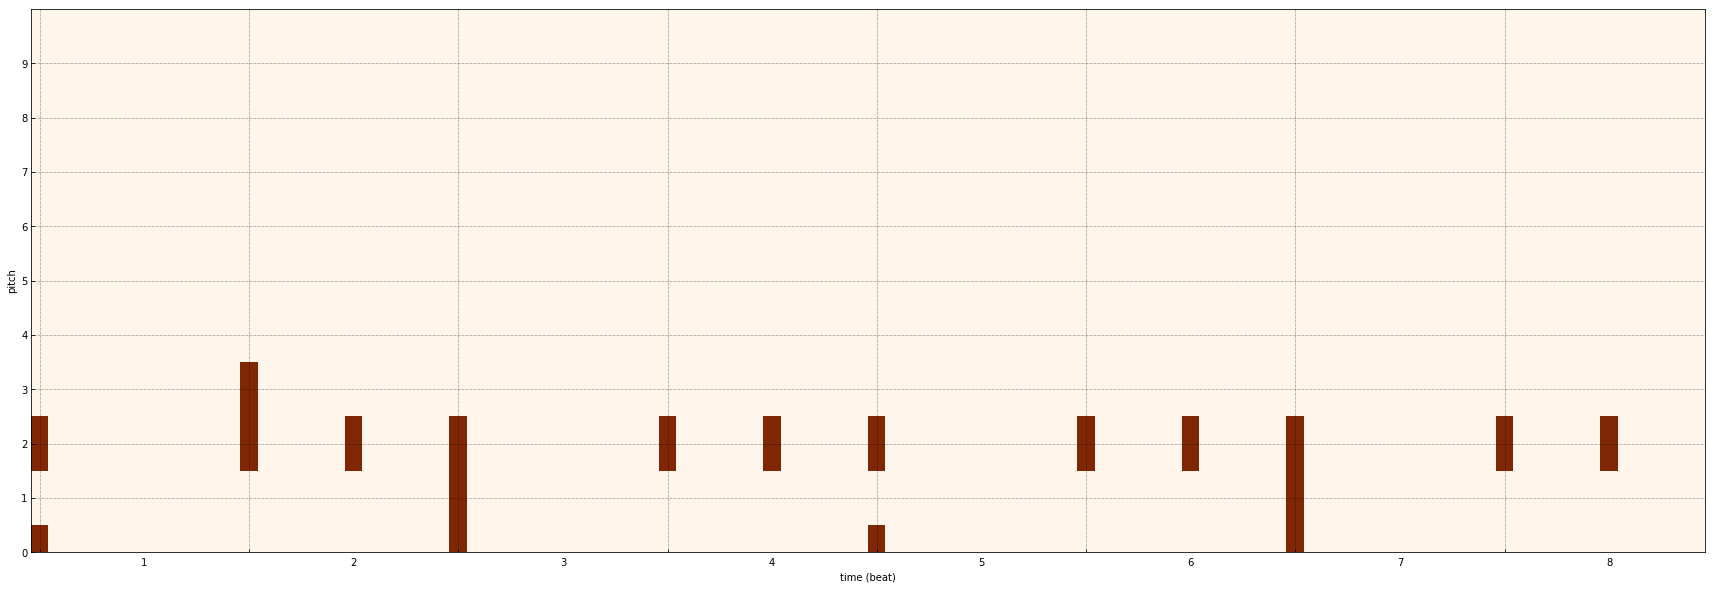

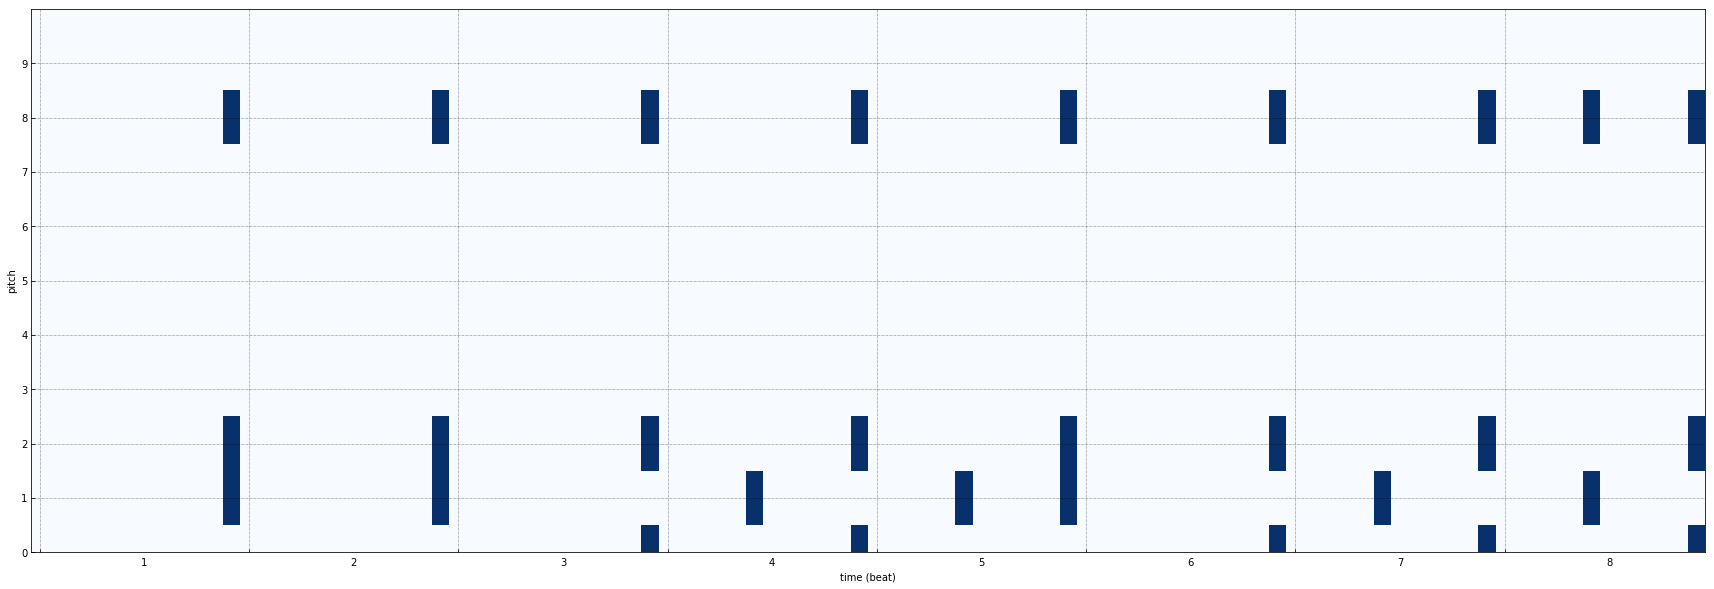

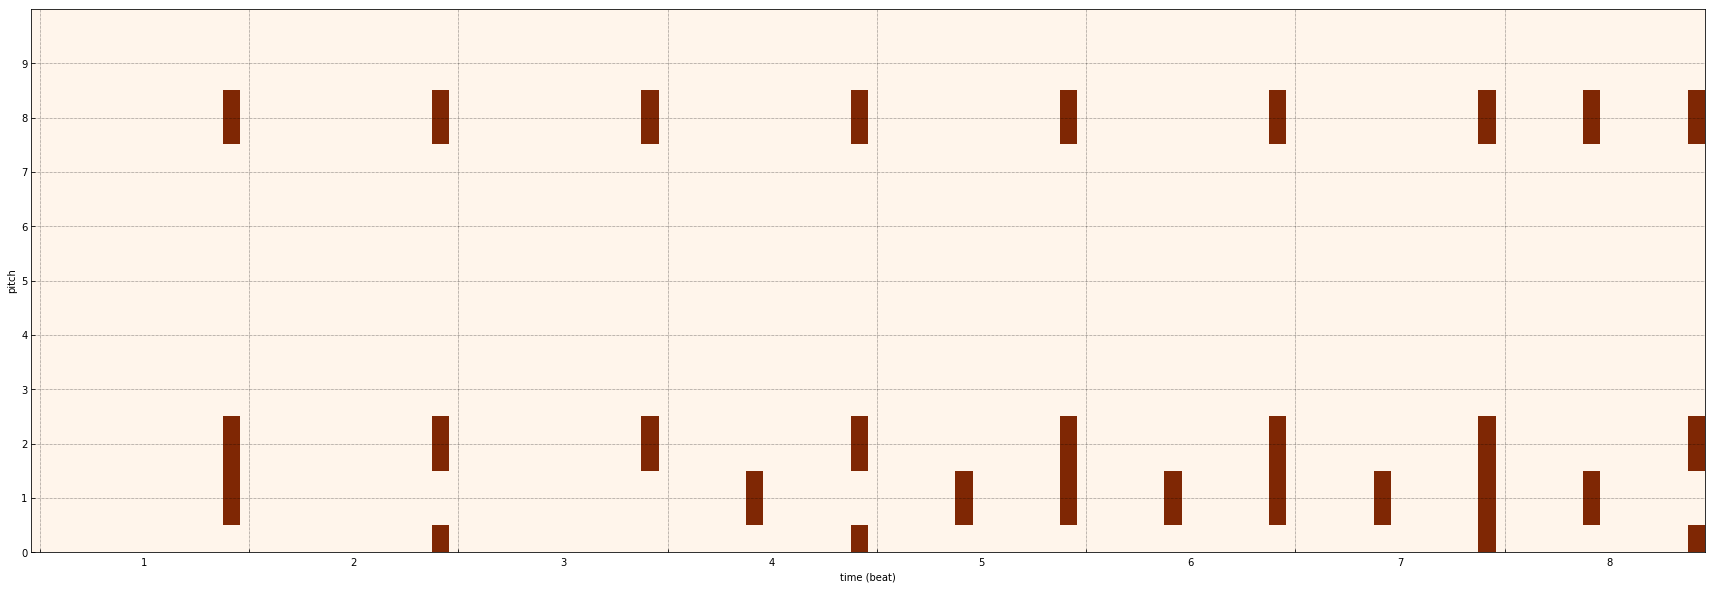

In [16]:
for batch_i, data in enumerate(test_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        data = Variable(data[0]).type(torch.float32).to(device)
        data_out = vae(data)
        
        
        for i in range(len(data)):
            if i < 2:
                data_i = data[i].cpu().data.numpy()
                data_o = data_out[i].cpu().data.numpy()
                data_o = np.where(data_o > 0.2, 1, 0)
                pltReducedDrumTrack(data_i)
                pltReducedDrumTrack(data_o, cmap='Oranges')

# 2. Interpolation

In [9]:
def slerp(a, b, steps=256):
    aa =  np.squeeze(a/np.linalg.norm(a))
    bb =  np.squeeze(b/np.linalg.norm(b))
    ttt = np.sum(aa*bb)
    omega = np.arccos(ttt)
    so = np.sin(omega)
    step_deg = 1 / (steps+1)
    step_list = []

    for idx in range(1, steps+1):
        t = step_deg*idx
        tmp = np.sin((1.0-t)*omega) / so * a + np.sin(t*omega)/so * b
        step_list.append(tmp)
    return step_list

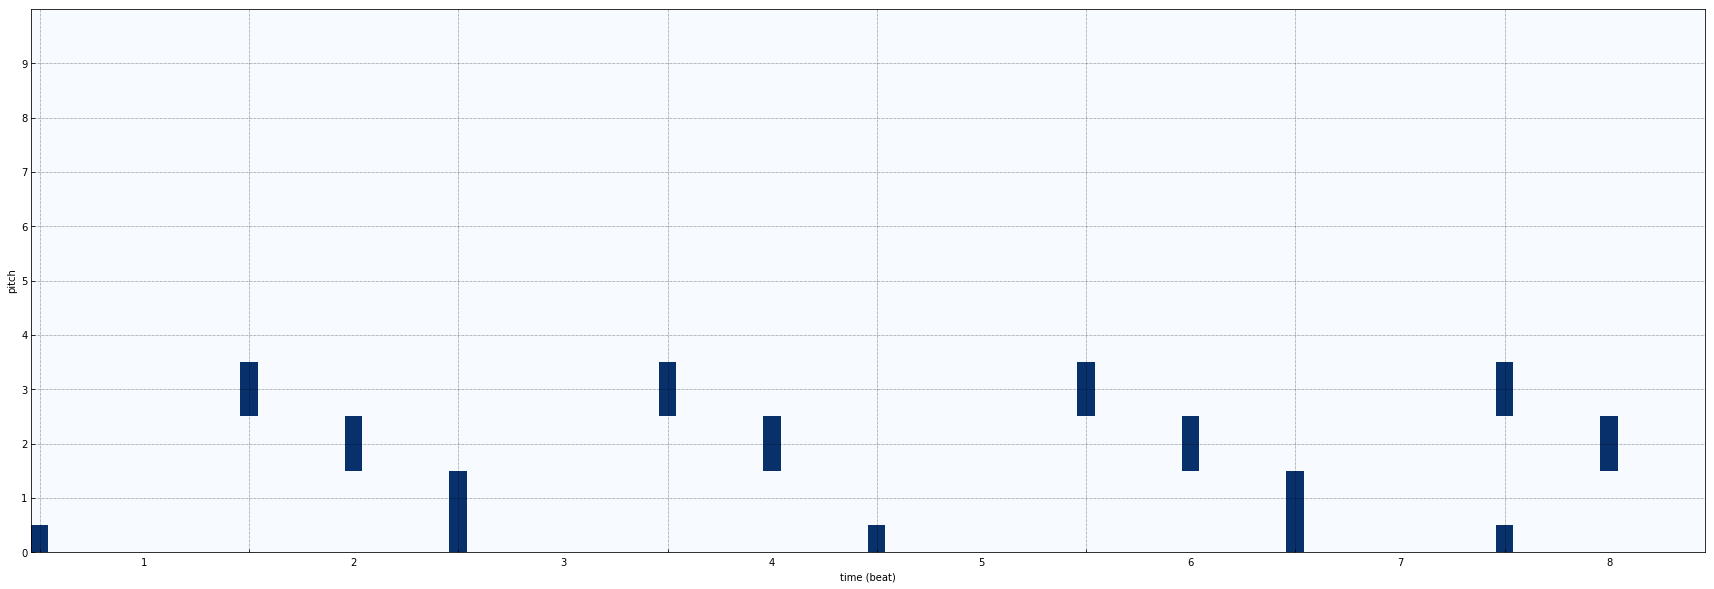

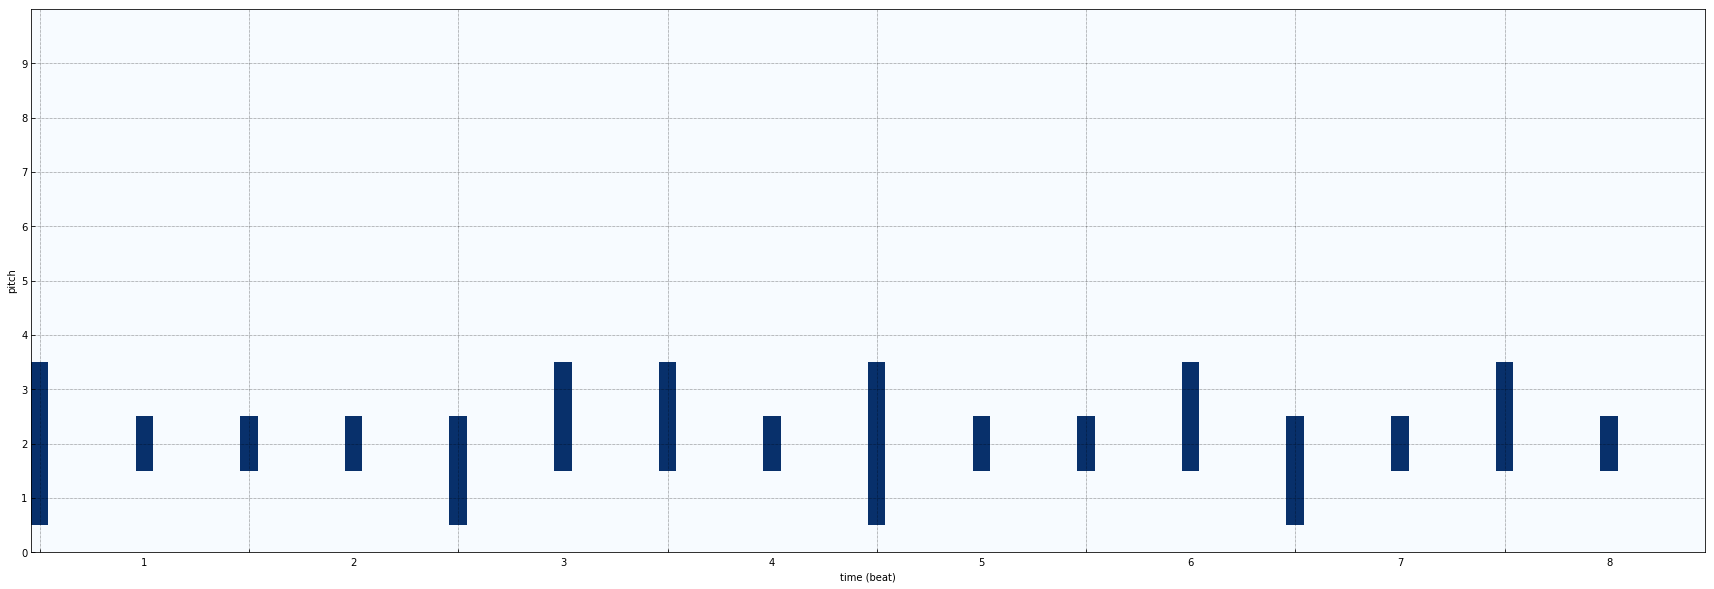

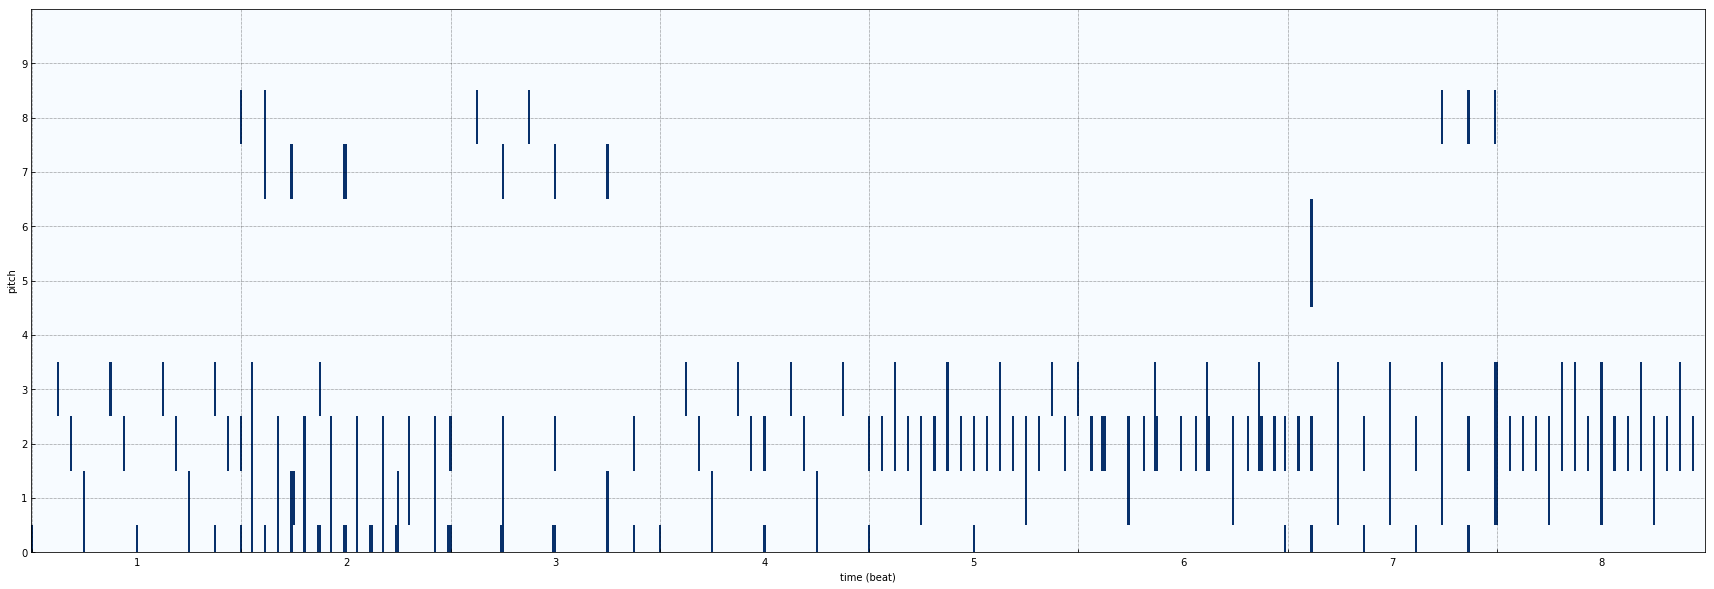

In [63]:
for batch_i, data in enumerate(train_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        pltReducedDrumTrack(data[0][0])
        pltReducedDrumTrack(data[0][1])
        data = Variable(data[0]).type(torch.float32).to(device)
        latent = encoder(data)
        steps = np.asarray(slerp(
            latent[0].cpu().data.numpy(),
            latent[1].cpu().data.numpy(),
        ))
        steps_out = decoder(
            vae._sample_latent(
                torch.from_numpy(steps).to(device)))
        
        out_concat = np.empty((0, 9))
        out_concat = np.concatenate(
            (out_concat, data[0].cpu().data.numpy()),
            axis=0)

        for i, step_i in enumerate(steps_out):
            if i % 50 == 0:
                o = step_i.cpu().data.numpy()
                o = np.where(o > 0.2, 128, 0)
                out_concat = np.concatenate(
                    (out_concat, o),
                    axis=0)
        out_concat = np.concatenate(
            (out_concat, data[1].cpu().data.numpy()),
            axis=0)

        writeData2Midi(out_concat)

        pltReducedDrumTrack(
            out_concat,
            beat_resolution=96,
        )